<a href="https://colab.research.google.com/github/juantijero/ML_HW/blob/main/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]



Starting training for Problem 1.a (2 Conv Layers)...
Model Size: 18,354 parameters
Epoch 50/300 | Loss: 1.5623 | Val Acc: 44.35%
Epoch 100/300 | Loss: 1.3811 | Val Acc: 51.39%
Epoch 150/300 | Loss: 1.2643 | Val Acc: 55.13%
Epoch 200/300 | Loss: 1.1853 | Val Acc: 57.52%
Epoch 250/300 | Loss: 1.1206 | Val Acc: 59.39%
Epoch 300/300 | Loss: 1.0642 | Val Acc: 60.80%
Finished Problem 1.a (2 Conv Layers). Time: 2179.47s | Final Acc: 60.80%

Starting training for Problem 1.b (3 Conv Layers)...
Model Size: 11,138 parameters
Epoch 50/300 | Loss: 1.7278 | Val Acc: 39.18%
Epoch 100/300 | Loss: 1.4603 | Val Acc: 47.71%
Epoch 150/300 | Loss: 1.3070 | Val Acc: 53.36%
Epoch 200/300 | Loss: 1.2107 | Val Acc: 56.67%
Epoch 250/300 | Loss: 1.1388 | Val Acc: 58.75%
Epoch 300/300 | Loss: 1.0801 | Val Acc: 61.20%
Finished Problem 1.b (3 Conv Layers). Time: 2177.21s | Final Acc: 61.20%


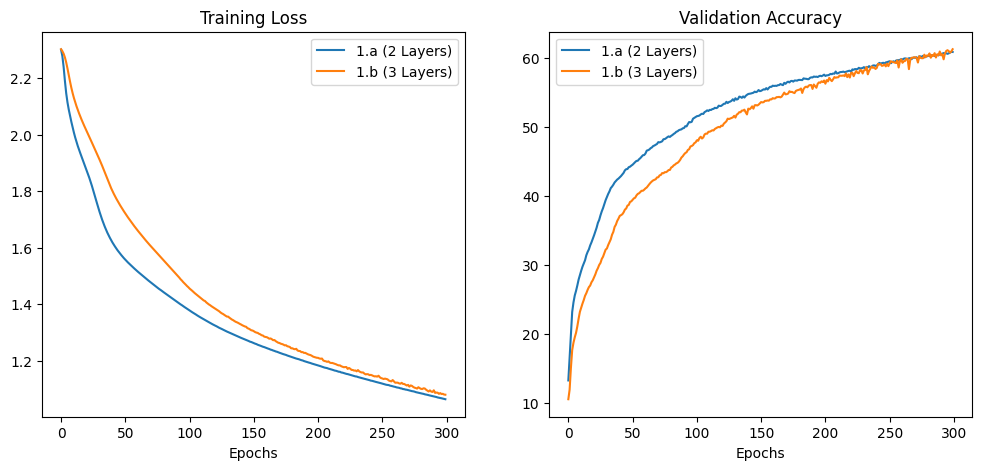

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 1. Data Loading (CIFAR-10)
# ==========================================
# Using batch_size=1024 since you have an A100
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, # High batch size for A100
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=1024,
                                         shuffle=False, num_workers=2)

# ==========================================
# 2. Model Definitions
# ==========================================

# --- Problem 1.a: Lecture 13 Architecture ---
class CNN_Lecture(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer 1: Conv -> Tanh -> Pool
        # Input: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2) # Output: 16 x 16 x 16

        # Layer 2: Conv -> Tanh -> Pool
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2) # Output: 8 x 8 x 8

        # Fully Connected Layers
        # Flattened size = 8 channels * 8 * 8 pixels = 512
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10) # 10 Classes for CIFAR-10

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # Flatten
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

# --- Problem 1.b: Deeper CNN (3 Conv Layers) ---
class CNN_Extended(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Increased channels to 32
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2) # Output: 32 x 16 x 16

        # Layer 2
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2) # Output: 16 x 8 x 8

        # Layer 3 (New Layer)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act3 = nn.Tanh()
        self.pool3 = nn.MaxPool2d(2) # Output: 8 x 4 x 4

        # Fully Connected
        # Flattened size = 8 channels * 4 * 4 pixels = 128
        self.fc1 = nn.Linear(8 * 4 * 4, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = out.view(-1, 8 * 4 * 4) # Flatten
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

# Helper to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ==========================================
# 3. Training Function
# ==========================================

def train_model(model, epochs, name="Model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-2) # Lecture 13 uses SGD

    train_losses = []
    val_accuracies = []
    start_time = time.time()

    print(f"\nStarting training for {name}...")
    print(f"Model Size: {count_parameters(model):,} parameters")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        train_losses.append(running_loss / len(trainloader))
        val_accuracies.append(epoch_acc)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | Val Acc: {epoch_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"Finished {name}. Time: {total_time:.2f}s | Final Acc: {val_accuracies[-1]:.2f}%")
    return train_losses, val_accuracies

# ==========================================
# 4. Run Training
# ==========================================

# Problem 1.a
model_1a = CNN_Lecture()
losses_1a, acc_1a = train_model(model_1a, epochs=300, name="Problem 1.a (2 Conv Layers)")

# Problem 1.b
model_1b = CNN_Extended()
losses_1b, acc_1b = train_model(model_1b, epochs=300, name="Problem 1.b (3 Conv Layers)")

# ==========================================
# 5. Plotting
# ==========================================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_1a, label='1.a (2 Layers)')
plt.plot(losses_1b, label='1.b (3 Layers)')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_1a, label='1.a (2 Layers)')
plt.plot(acc_1b, label='1.b (3 Layers)')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 1. Data Loading (Same as Problem 1)
# ==========================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Batch size 1024 for A100 speed
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=1024, shuffle=False, num_workers=2)

# ==========================================
# 2. ResNet Definition (Lecture 14, Page 14-15)
# ==========================================

class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        # Conv layer (Lecture 14, Page 14)
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)

        # Batch Norm (Included by default in lecture ResBlock)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)

        # Kaiming Initialization (Lecture 14, Page 14)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x # The Skip Connection

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10, use_dropout=False):
        super().__init__()
        self.n_chans1 = n_chans1
        self.use_dropout = use_dropout

        # Initial Conv Layer
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)

        # Stack of ResBlocks (Lecture 14, Page 15)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )

        # Final Fully Connected Layers
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10) # 10 Classes for CIFAR-10

        # Dropout (for Part 2b)
        self.dropout = nn.Dropout(p=0.3) if use_dropout else nn.Identity()

    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = torch.max_pool2d(out, 2)

        out = self.resblocks(out)

        out = torch.max_pool2d(out, 2)

        out = out.view(-1, 8 * 8 * self.n_chans1)

        out = torch.relu(self.fc1(out))
        out = self.dropout(out) # Apply dropout if enabled
        out = self.fc2(out)
        return out

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ==========================================
# 3. Training Function
# ==========================================

def train_resnet(model, epochs, weight_decay=0.0, name="Model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    # Lecture 14 mentions learning rate 3e-3 for ResNets
    optimizer = optim.SGD(model.parameters(), lr=3e-3, weight_decay=weight_decay)

    train_losses = []
    val_accuracies = []
    start_time = time.time()

    print(f"\nStarting training for {name}...")
    print(f"Model Size: {count_parameters(model):,} parameters")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        train_losses.append(running_loss / len(trainloader))
        val_accuracies.append(epoch_acc)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | Val Acc: {epoch_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"Finished {name}. Time: {total_time:.2f}s | Final Acc: {val_accuracies[-1]:.2f}%")
    return train_losses, val_accuracies, total_time

# ==========================================
# 4. Execution Block (Run this when ready)
# ==========================================

# --- Problem 2.a: Baseline ResNet-10 ---
print("--- Running Problem 2.a (Baseline ResNet-10) ---")
model_2a = NetResDeep(n_blocks=10, use_dropout=False)
losses_2a, acc_2a, time_2a = train_resnet(model_2a, epochs=300, name="ResNet-10 (Baseline)")

# --- Problem 2.b: Weight Decay ---
print("\n--- Running Problem 2.b (Weight Decay) ---")
model_2b_wd = NetResDeep(n_blocks=10, use_dropout=False)
losses_2b_wd, acc_2b_wd, time_2b_wd = train_resnet(model_2b_wd, epochs=300, weight_decay=0.001, name="ResNet-10 + Weight Decay")

# --- Problem 2.b: Dropout ---
print("\n--- Running Problem 2.b (Dropout) ---")
model_2b_drop = NetResDeep(n_blocks=10, use_dropout=True)
losses_2b_drop, acc_2b_drop, time_2b_drop = train_resnet(model_2b_drop, epochs=300, name="ResNet-10 + Dropout")

# --- Problem 2.b: Batch Norm ---
# Note: The lecture's ResBlock ALREADY includes Batch Norm by default.
# So the "Baseline" model (2.a) actually represents the "Batch Norm" case.
# You can just reference the 2.a results for this part of the report.